In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import micromagneticdata as md
from cycler import cycler
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'

In [ ]:
oc.runner.runner = oc.oommf.DockerOOMMFRunner()

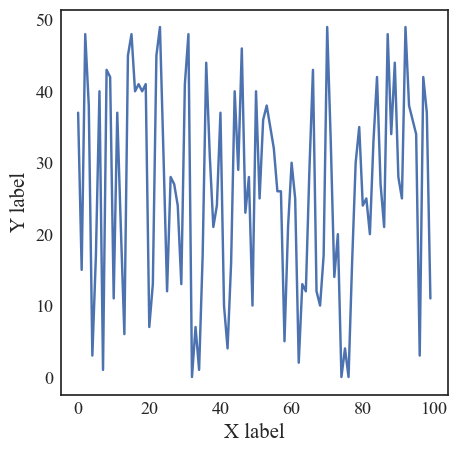

In [2]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(100),np.random.randint(50,size=100))
ax.set_xlabel('X label')
ax.set_ylabel('Y label')
plt.show()

In [64]:
l = 200e-9
w = 50e-9
region=df.Region(p1=(-l,-w,0),p2=(l,w,3e-9))
subregions={'bottom':df.Region(p1=(-l,-w,0),p2=(l,w,1e-9)),
            'spacer':df.Region(p1=(-l,-w,1e-9),p2=(l,w,2e-9)),
            'top':df.Region(p1=(-l,-w,2e-9),p2=(l,w,3e-9))}
cell=(2e-9,2e-9,1e-9)
mesh=df.Mesh(region=region,cell=cell,subregions=subregions)

In [69]:
Ms={'bottom':0.58e6,'spacer':0,'top':0.58e6}
A={'bottom':15e-12,'spacer':0,'top':15e-12}
D={'bottom':3e-3,'spacer':0,'top':3e-3}
def K_gai(pos):
    x,y,z=pos
    if 0 <= x <= 100e-9:
        return 0.8e6 + 0.08*1e6 * x/100e-9
    else:
        return 0.8e6
K=df.Field(mesh,dim=1,value=K_gai)

In [70]:
def m_init(pos):
    x,y,z=pos
    if 0 <= z < 1e-9:
        if ((x-150e-9)**2+y**2)**0.5 <= 15e-9:
            return (0,0,-1)
        else:
            return (0,0,1)
    else:
        if ((x-150e-9)**2+y**2)**0.5 <= 15e-9:
            return (0,0,1)
        else:
            return (0,0,-1)

In [71]:
system = mm.System(name='wenzhang2')
system.energy = mm.Exchange(A=A)+mm.UniaxialAnisotropy(K=K,u=(0,0,1))\
            +mm.Demag()+mm.DMI(D=D,crystalclass='Cnv_z')\
            +mm.RKKY(sigma=-2e-3,sigma2=0,subregions=['bottom','top'])
system.dynamics = mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.1)
system.m = df.Field(mesh,dim=3,value=m_init,norm=Ms)
td=oc.TimeDriver()
td.drive(system,t=0.1e-9,n=10)

Running OOMMF (DockerOOMMFRunner)[2022/09/20 14:59]... (46.6 s)


In [72]:
system.dynamics += mm.Slonczewski(J=-20*(1e10),mp=(0,1,0),P=0.4,Lambda=1,eps_prime=0)
td.drive(system,t=2e-9,n=200)

Running OOMMF (DockerOOMMFRunner)[2022/09/20 15:02]... (695.8 s)


In [31]:
td.drive(system,t=0.3e-9,n=20)

Running OOMMF (DockerOOMMFRunner)[2022/07/29 13:16]... (115.4 s)


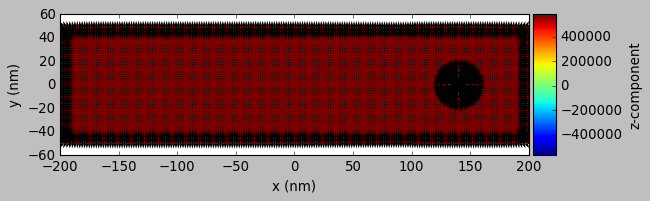

In [7]:
plt.style.use('classic')
system.m.plane(z=0).mpl()

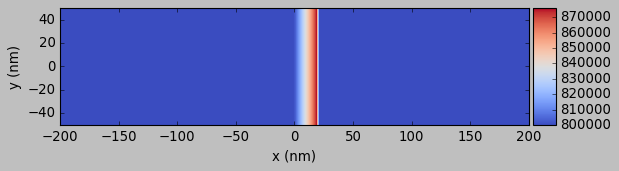

In [27]:
#找文件
plt.style.use('classic')
df.Field.fromfile(r'f:\Tep\wenzhang2\drive-{}\uniaxialanisotropy_K.ovf'.format(12)).x.plane(z=25e-10).mpl.scalar(cmap='coolwarm',alpha=1)

In [2]:
#读取数据
import os
import pandas as pd
file_path = 'f:/csv_file/wenzhang2_EpL.csv'
if not os.path.exists('f:/csv_file'):
    os.mkdir('f:/csv_file')
dfa = pd.read_csv(file_path)

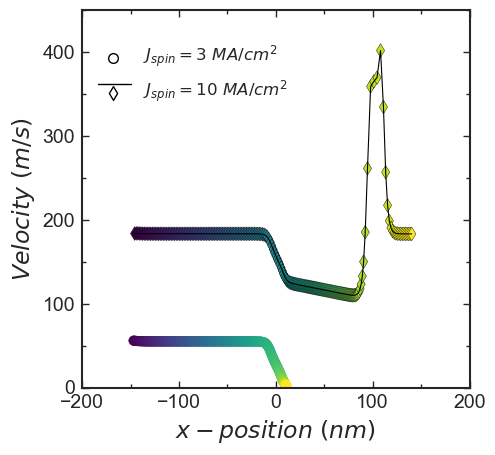

In [20]:
#图1
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.markersize'] = 7
dfa = pd.read_csv('f:/csv_file/wenzhang2_tu1_xv.csv')
data = md.Data(name='wenzhang2')
t = data[-1].table.data['t']
plt.style.use('seaborn-white')
fig, ax = plt.subplots(dpi=100,figsize=(5,5))
ax.scatter(dfa['PX3'][1:],dfa['Pv3'][1:],c=t[1:-1],cmap='viridis',marker='o')
ax.scatter(dfa['PX10'][1:],dfa['Pv10'][1:],c=t[1:-1],cmap='viridis',marker='d',edgecolors='k',
           linewidth=0.3)
ax.plot(dfa['PX10'][1:],dfa['Pv10'][1:],lw=0.8,c='k')
ax.set(xlim=(-200,200),ylim=(0,450))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.tick_params(axis='both',which='minor',length=3,direction='in',width=1)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=14)
ax.set_xlabel(r'$x-position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Velocity\ (m/s)$',fontsize=17)
ax.spines[['bottom','left','top','right']].set_lw(1.5)
marker1 = ax.scatter([],[],facecolors='w',edgecolors='k',marker='o',linewidth=1)
marker2 = ax.scatter([],[],facecolors='w',edgecolors='k',marker='d',linewidth=1)
marker3, = ax.plot([],[],c='k',lw=1,markerfacecolor='w',markeredgecolor='k',markeredgewidth=1)
first_legend = ax.legend(handles=[marker1,marker2],bbox_to_anchor=(0.57,0.95),labels=[r'$J_{spin}=3\ MA/{cm}^{2}$',r'$J_{spin}=10\ MA/{cm}^{2}$'])
ax.add_artist(first_legend)
ax.legend(handles=[marker3],bbox_to_anchor=(0.199,0.86),labels=[''])
plt.savefig('f:/tupian/wenzhang2/tu1(1).eps',dpi=600,bbox_inches='tight')
plt.show()

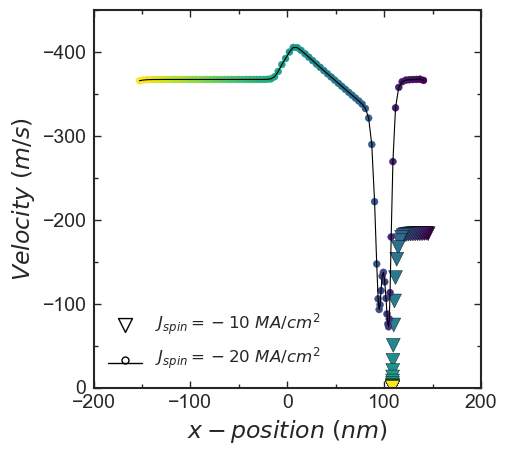

In [5]:
#图1
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.markersize'] = 5
dfa = pd.read_csv('f:/csv_file/wenzhang2_tu1_xv.csv')
data = md.Data(name='wenzhang2')
t = data[-3].table.data['t']
plt.style.use('seaborn-white')
fig, ax = plt.subplots(dpi=100,figsize=(5,5))
ax.scatter(dfa['NX10'][1:-150],-dfa['Nv10'][1:-150],c=t[1:-151],cmap='viridis',s=100,marker='v',edgecolors='k',linewidth=0.3)
ax.scatter(dfa['NX20'][1:-106],-dfa['Nv20'][1:-106],c=t[1:-107],cmap='viridis',marker='o')
ax.plot(dfa['NX20'][1:-106],-dfa['Nv20'][1:-106],c='k',lw=0.8)
ax.set(xlim=(-200,200),ylim=(0,-450))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.tick_params(axis='both',which='minor',length=3,direction='in',width=1)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=14)
ax.set_xlabel(r'$x-position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Velocity\ (m/s)$',fontsize=17)
ax.spines[['bottom','left','top','right']].set_lw(1.5)
marker1 = ax.scatter([],[],facecolors='w',edgecolors='k',marker='v',linewidth=1,s=100)
marker2 = ax.scatter([],[],facecolors='w',edgecolors='k',marker='o',linewidth=1)
marker3, = ax.plot([],[],c='k',lw=1,markerfacecolor='w',markeredgecolor='k',markeredgewidth=1)
first_legend = ax.legend(handles=[marker1,marker2],loc='best',labels=[r'$J_{spin}=-10\ MA/{cm}^{2}$',r'$J_{spin}=-20\ MA/{cm}^{2}$'])
ax.add_artist(first_legend)
ax.legend(handles=[marker3],bbox_to_anchor=(0.197,0.122),labels=[''])
plt.savefig('f:/tupian/wenzhang2/tu1(2).eps',dpi=600,bbox_inches='tight')
plt.show()

In [184]:
dfa[dfa['Pv10'] == dfa.loc[:,'Pv10'].min()]

,PX3,Pv3,PX10,Pv10,NX10,Nv10,NX20,Nv20
164,7.774179,7.527601,79.830404,109.941163,108.594506,0.000403,-179.985569,0.003007


In [19]:
#正方向的平均力
F_ave = []
L = ['L20','X20','L40','X40','L60','X60','L80','X80','L100','X100']
for i in range(9):
    if i % 2 == 0:
        N_max = dfa[dfa[L[i]] == dfa[L[i]].max()].index.to_list()[0]
        N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 0.3].index.to_list()[0]
        f_ave = (dfa.diff()[L[i]][N_0:N_max+1] / dfa.diff()[L[i+1]][N_0:N_max+1]).mean()
        F_ave.append(f_ave)
    else:
        pass
F_ave

C:\Users\86293\AppData\Local\Temp\ipykernel_17300\4186852781.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 0.3].index.to_list()[0]


[1.4250361498415767e-21,
 1.7281178338789926e-21,
 1.3008259225672873e-21,
 1.0334082147799883e-21,
 8.561771326043765e-22]

C:\Users\86293\AppData\Local\Temp\ipykernel_17300\1617135539.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 0.3].index.to_list()[0]


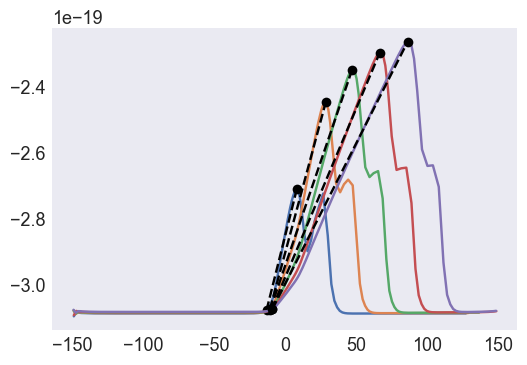

[1.7206771931384508e-21,
 1.5942991064798499e-21,
 1.2578627854868991e-21,
 1.020692408591564e-21,
 8.490412578571875e-22]

In [18]:
#正方向的平均力
F_ave = []
L = ['L20','X20','L40','X40','L60','X60','L80','X80','L100','X100']
fig, ax = plt.subplots(dpi=100)
for i in range(9):
    if i % 2 == 0:
        N_max = dfa[dfa[L[i]] == dfa[L[i]].max()].index.to_list()[0]
        N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 0.3].index.to_list()[0]
        f_ave = (dfa[L[i]][N_max] - dfa[L[i]][N_0])/(dfa[L[i+1]][N_max] - dfa[L[i+1]][N_0])
        F_ave.append(f_ave)
        ax.plot(dfa[L[i+1]],dfa[L[i]])
        ax.plot([dfa[L[i+1]][N_0],dfa[L[i+1]][N_max]],[dfa[L[i]][N_0],dfa[L[i]][N_max]],'--o',c='k')
    else:
        pass
plt.show()
F_ave

In [13]:
#力的准确值（正向）
file_path = 'f:/csv_file/wenzhang2_J11_xv.csv'
file_path1 = 'f:/csv_file/wenzhang2_EpL.csv'
dfa = pd.read_csv(file_path)
dfa1 = pd.read_csv(file_path1)
x = 'X100'
v = 'v100'
l = 'L100'
x_d = dfa1[dfa1[l] == dfa1[l].max()].index.values[0]
(dfa1.diff()[l]/dfa1.diff()[x])[x_d-5:x_d+5]

163    8.460430e-22
164    8.226722e-22
165    7.720425e-22
166    6.752373e-22
167    5.539507e-22
168    3.014519e-22
169   -1.169478e-22
170   -8.379468e-22
171   -2.176726e-21
172   -4.342989e-21
dtype: float64

In [128]:
3*2.5*1000/(0.4*np.pi*1.3*33)

139.12145375165676

In [ ]:
#求delta K 的 b 值
file_path = 'f:/csv_file/wenzhang2_EpK.csv'
dfa = pd.read_csv(file_path)

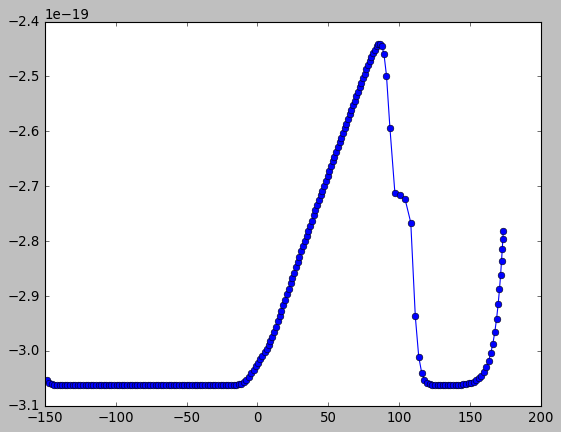

In [112]:
plt.style.use('classic')
x = 'X60'
k = 'K60'
x_d = dfa[dfa[k] == dfa[k].max()].index.values[0]
plt.plot(dfa[x],dfa[k],'-o')
plt.show()

In [117]:
dfa[x][158] - dfa[x][165]

-17.329919376633228

In [113]:
dfa[k][x_d:x_d+20]

151   -2.440688e-19
152   -2.444797e-19
153   -2.459705e-19
154   -2.498623e-19
155   -2.593481e-19
156   -2.711920e-19
157   -2.715358e-19
158   -2.724298e-19
159   -2.766429e-19
160   -2.937566e-19
161   -3.011218e-19
162   -3.039990e-19
163   -3.053062e-19
164   -3.058791e-19
165   -3.061365e-19
166   -3.062475e-19
167   -3.062923e-19
168   -3.063073e-19
169   -3.063090e-19
170   -3.063050e-19
Name: K60, dtype: float64

In [2]:
#力的准确值（反向）
file_path = 'f:/csv_file/wenzhang2_J11_xv.csv'
file_path1 = 'f:/csv_file/wenzhang2_EpL.csv'
dfa = pd.read_csv(file_path)
dfa1 = pd.read_csv(file_path1)
x = 'X20'
xj = 'XJ20'
v = 'v20'
l = 'L20'
x_d = dfa[dfa[v] == dfa[v].min()].index.values[0]
x_0 = dfa[dfa.diff()[v] <= -0.5].index.values[0]
dfa[x][x_d] - dfa[x][x_0]

21.574704520332176

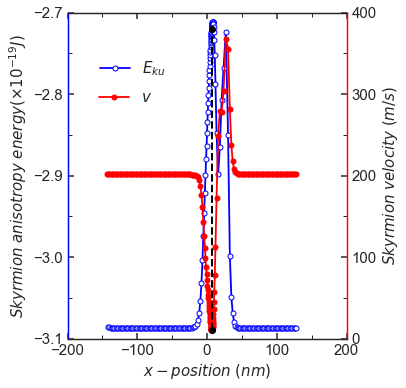

In [5]:
#双y轴
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1.8
plt.style.use('seaborn-white')
plt.figure(figsize=(5,6))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(dfa1[x][4:],dfa1[l][4:]*1e19,c='b',marker='o',
         markeredgecolor='b',markerfacecolor='w',label=r'$E_{ku}$')
ax2.plot(dfa[x][2:], dfa[v][2:],'-o',c='r',markerfacecolor='r',label=r'$v$')
ax1.plot(dfa1[x][x_d],dfa1[l][x_d]*1e19,'o',c='k',markerfacecolor='k',markersize=6)
ax2.plot(dfa[x][x_d], dfa[v][x_d],'o',c='k',markerfacecolor='k',markersize=6)
ax2.plot([dfa[x][x_d],dfa[x][x_d]], [dfa[v][x_d],385],'--',c='k',lw=2)
ax1.spines['right'].set_color('r')
ax1.spines['left'].set_color('b')
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')
ax1.set_xlabel(r'$x-position\ (nm)$',fontsize=15)
ax1.set_ylabel(r'$Skyrmion\ anisotropy\ energy(\times10^{-19}J)$',fontsize=15)
ax2.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=15)
ax1.set(xlim=(-200,200),ylim=(-3.1,-2.7))
ax2.set(ylim=(0,400))
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')
ax1.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax1.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15,width=1.5)
ax2.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax2.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15,width=1.5)
ax1.xaxis.set_major_locator(plt.MultipleLocator(100))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax2.yaxis.set_major_locator(plt.MultipleLocator(100))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax1.legend(bbox_to_anchor=(0.4,0.9),fontsize=15)
ax2.legend(bbox_to_anchor=(0.35,0.8),fontsize=15)
plt.savefig('f:/tupian/wenzhang2/Dy_L20.eps',dpi=600,bbox_inches='tight')
plt.show()

In [2]:
dfa = pd.read_csv('f:/csv_file/wenzhang2_tu1_xv.csv')
x_d = dfa[:50][dfa[:50]['Nv20'] == dfa[:50]['Nv20'].min()].index.values[0]
x_0 = dfa[dfa.diff()['Nv20'] <= -0.5].index.values[0]
dfa.diff()['NE20'][x_d-2:x_d+3]
x_0

6

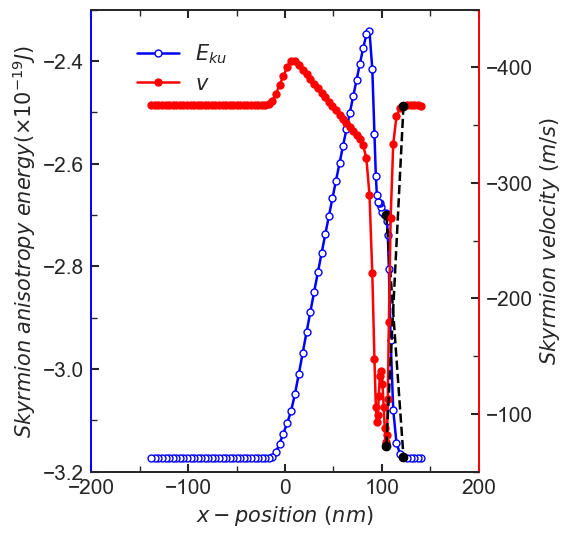

In [6]:
#双y轴
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1.8
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5,6))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(dfa['NX20'][1:-110],dfa['NE20'][1:-110]*1e19,c='b',marker='o',
         markeredgecolor='b',markerfacecolor='w',label=r'$E_{ku}$')
ax2.plot(dfa['NX20'][1:-110], -dfa['Nv20'][1:-110],'-o',c='r',markerfacecolor='r',label=r'$v$')
ax1.plot([dfa['NX20'][x_d],dfa['NX20'][x_0]], [dfa['NE20'][x_d]*1e19,dfa['NE20'][x_0]*1e19],
        '--o',c='k',markerfacecolor='k',markersize=6)
ax2.plot([dfa['NX20'][x_d],dfa['NX20'][x_0]], [-dfa['Nv20'][x_d],-dfa['Nv20'][x_0]],
        '--o',c='k',markerfacecolor='k',markersize=6)
ax1.spines['right'].set_color('r')
ax1.spines['left'].set_color('b')
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')
ax1.set_xlabel(r'$x-position\ (nm)$',fontsize=15)
ax1.set_ylabel(r'$Skyrmion\ anisotropy\ energy(\times10^{-19}J)$',fontsize=15)
ax2.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=15)
ax1.set(xlim=(-200,200),ylim=(-3.2,-2.3))
ax2.set(ylim=(-50,-450))
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')
ax1.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax1.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15,width=1.5)
ax2.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax2.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15,width=1.5)
ax1.xaxis.set_major_locator(plt.MultipleLocator(100))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(plt.MultipleLocator(100))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax1.legend(bbox_to_anchor=(0.4,0.97),fontsize=15)
ax2.legend(bbox_to_anchor=(0.355,0.9),fontsize=15)
plt.savefig('f:/tupian/wenzhang2/Dy_K80.eps',dpi=600,bbox_inches='tight')
plt.show()

In [37]:
4.57 * 3 / (12 * np.pi * 0.13)

2.7974541920383147

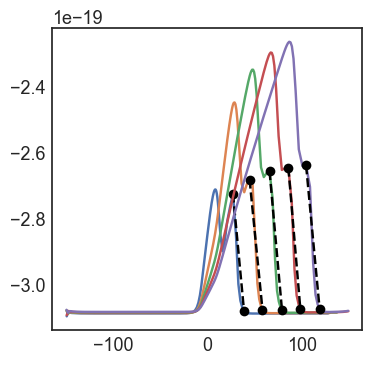

[-2.0657528482940606e-21,
 -2.2971060137753558e-21,
 -2.464296015082424e-21,
 -2.5879105823360724e-21,
 -2.3727883967862e-21]

In [2]:
#负方向的平均力
from scipy.signal import argrelextrema
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpL.csv')
plt.style.use('seaborn-white')
F_ave = []
L = ['L20','X20','L40','X40','L60','X60','L80','X80','L100','X100']
fig, ax = plt.subplots(dpi=100,figsize=(4,4))
for i in range(9):
    if i % 2 == 0:
        N_max = dfa[dfa[L[i]] == dfa[L[i]].max()].index.to_list()[0]
        N_0 = dfa[N_max:].loc[dfa[N_max:].diff()[L[i]].abs()*1e21 >= 0.7,L[i]].index.to_list()[-1]
        N_mid = N_max + argrelextrema(dfa.loc[N_max:N_0,L[i]].values,np.greater)[0][0]
        ax.plot(dfa[L[i+1]],dfa[L[i]])
        ax.plot([dfa.loc[N_mid,L[i+1]],dfa.loc[N_0,L[i+1]]],[dfa.loc[N_mid,L[i]],dfa.loc[N_0,L[i]]],'--o',c='k')
        f_ave = (dfa.diff()[L[i]][N_mid:N_0+1] / dfa.diff()[L[i+1]][N_mid:N_0+1]).mean()
        F_ave.append(f_ave)
    else:
        pass
plt.show()
F_ave

In [ ]:
#修改csv参数
file_path = 'f:/csv_file/wenzhang2_J18_xv.csv'
dfa = pd.read_csv(file_path)
x = 'X20'
v = 'v20'
n = dfa[dfa[x] <= -150].index.values[0] - dfa[x].index.values[-1]
dfa[v][-1:n:-1] = [np.nan] * len(dfa[v][-1:n:-1])
dfa[x][-1:n:-1] = [np.nan] * len(dfa[x][-1:n:-1])
plt.plot(dfa[x],dfa[v],'-o')
plt.show()
dfa.to_csv('f:/csv_file/wenzhang2_J18_xv.csv',index=False)

C:\Users\86293\AppData\Local\Temp\ipykernel_18804\2305115454.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 1].index.to_list()[0]


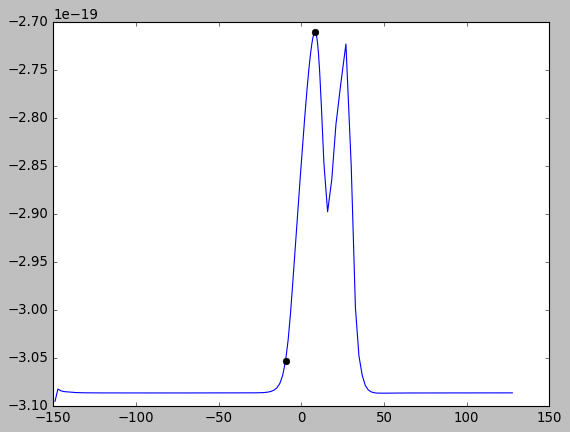

In [39]:
#证明图(正向)
i = 0
j = i+1
N_max = dfa[dfa[L[i]] == dfa[L[i]].max()].index.to_list()[0]
N_0 = dfa[10:N_max+1][dfa.diff()[L[i]]*1e21 >= 1].index.to_list()[0]
plt.plot(dfa[L[j]],dfa[L[i]])
plt.plot(dfa[L[j]][N_0],dfa[L[i]][N_0],'o',c='k')
plt.plot(dfa[L[j]][N_max],dfa[L[i]][N_max],'o',c='k')
plt.show()

In [11]:
#变化K平均斜率
K1 = -2.64
K2 = -2.44
K3 = -2.24
K4 = -2.04
K5 = -1.79
K0 = -3.06
x1 = 86.5
x0 = -12
x2 = 119
print(((K1-K0)/(x1-x0),(K2-K0)/(x1-x0),(K3-K0)/(x1-x0),(K4-K0)/(x1-x0),(K5-K0)/(x1-x0)))
print(((K1-K0)/(x2-x1),(K2-K0)/(x2-x1),(K3-K0)/(x2-x1),(K4-K0)/(x2-x1),(K5-K0)/(x2-x1)))

(0.004263959390862943, 0.0062944162436548235, 0.0083248730964467, 0.010355329949238578, 0.012893401015228427)
(0.01292307692307692, 0.01907692307692308, 0.025230769230769227, 0.031384615384615386, 0.03907692307692308)


In [41]:
#变化L平均斜率
X5, L5 = 86.5-(-12), -2.26
X4, L4 = 67+11.5, -2.30
X3, L3 = 47.4+11, -2.35
X2, L2 = 28.7+10.5, -2.45
X1, L1 = 8.3-(-10), -2.71
X0, L0 = -12, -3.08
l1, l2, l3, l4, l5 = 26,27,29.5,31.25,32
print((L1-L0)/22,(L2-L0)/38.5,(L3-L0)/56.1,(L4-L0)/75,(L5-L0)/98.5)
print((L1-L0)/l1,(L2-L0)/l2,(L3-L0)/l3,(L4-L0)/l4,(L5-L0)/l5)

0.016818181818181822 0.01636363636363636 0.01301247771836007 0.010400000000000003 0.008324873096446703
0.014230769230769234 0.02333333333333333 0.024745762711864405 0.024960000000000006 0.02562500000000001


In [64]:
#寻找数据点
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpL.csv')
x_max = dfa[dfa['L100'] == dfa['L100'].max()].index.values[0]
x_0 = dfa[dfa.diff()['L100']*1e19 >= 0.005].index.values[0]
x_1 = dfa[x_max:x_max+10][dfa[x_max:x_max+10].diff()['L100']*1e19 >= 0].index.values[0]
x_2 = dfa[x_1:x_1+20][dfa[x_1:x_1+20].diff()['L100']*1e19 >= 0].index.values[0]
print(x_max, x_0, x_1, x_2)

168 88 175 185


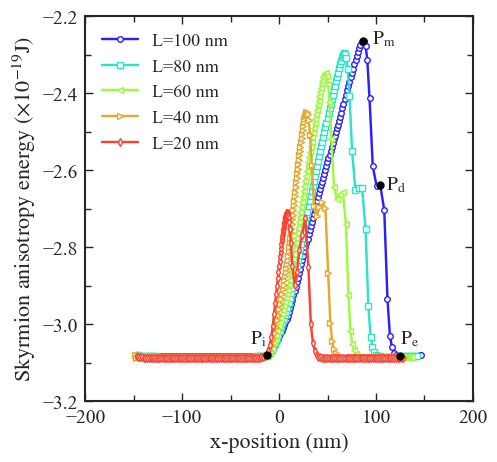

In [28]:
#各向异性能_L
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpL.csv')
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['lines.markeredgewidth'] = 1
custom_cycler = (cycler(color=['#291FFF'] + ['#2DE3C8'] + ['#9FFA3E'] + ['#E3AA2D'] + ['#FB4232']) +
                 cycler(markeredgecolor=['#291FFF'] + ['#2DE3C8'] + ['#9FFA3E'] + ['#E3AA2D'] + ['#FB4232']) +
                 cycler(marker=['o'] + ['s'] + ['<'] + ['>'] + ['d']) +
                 cycler(markerfacecolor=['w'] + ['w'] + ['w'] + ['w'] + ['w']))
fig, ax = plt.subplots(figsize=(5,5))
ax.set_prop_cycle(custom_cycler)
ax.plot(dfa['X100'][1:-5],dfa['L100'][1:-5]*1e19,label='L=100 nm')
ax.plot(dfa['X80'][1:-20],dfa['L80'][1:-20]*1e19,label='L=80 nm')
ax.plot(dfa['X60'],dfa['L60']*1e19,label='L=60 nm')
ax.plot(dfa['X40'],dfa['L40']*1e19,label='L=40 nm')
ax.plot(dfa['X20'][1:],dfa['L20'][1:]*1e19,label='L=20 nm')
ax.plot([dfa['X100'][168],dfa['X100'][175],dfa['X100'][85],dfa['X100'][183]],
        np.array([dfa['L100'][168],dfa['L100'][175],dfa['L100'][85],dfa['L100'][183]])*1e19,
        c='black',lw=0,marker='o',markersize=5,markerfacecolor='k',markeredgecolor='k')
ax.annotate(r'$\mathrm{P_{m}}$', xy=(dfa['X100'][168],dfa['L100'][168]*1e19), 
            xytext=(96, -2.27),fontsize=14)
ax.annotate(r'$\mathrm{P_{d}}$', xy=(dfa['X100'][175],dfa['L100'][175]*1e19), 
            xytext=(110, -2.65),fontsize=14)
ax.annotate(r'$\mathrm{P_{i}}$', xy=(dfa['X100'][85],dfa['L100'][85]*1e19), 
            xytext=(-30, -3.05),fontsize=14)
ax.annotate(r'$\mathrm{P_{e}}$', xy=(dfa['X100'][183],dfa['L100'][183]*1e19), 
            xytext=(125, -3.05),fontsize=14)
ax.spines[['bottom','left','top','right']].set_lw(1.5)
ax.set_xlabel('x-position (nm)',fontsize=16)
ax.set_ylabel(r'$\mathrm{Skyrmion\ anisotropy\ energy\ (\times10^{-19}J)}$',fontsize=16)
ax.set(xlim=(-200,200),ylim=(-3.2,-2.2))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=4,width=1,direction='in')
ax.tick_params(axis='both',which='major',length=6,width=1,direction='in',labelsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.legend(loc='best',fontsize=13)
plt.savefig('f:/tupian/wenzhang2/PE_L.png',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
#正反向各向异性能比较
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpL.csv')
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfa['X100'][5:-6],dfa['L100'][5:-6]*1e19,color='blue',
        marker='s',markeredgecolor='blue',markerfacecolor='white',label=r'$\mathrm{J=11\ MA/cm^{2}}$')
ax.plot(dfa['XJ100'][3:-3],dfa['LJ100'][3:-3]*1e19,color='red',
        marker='o',markeredgecolor='red',markerfacecolor='red',label=r'$\mathrm{J=-18\ MA/cm^{2}}$')
ax.spines[['bottom','left','top','right']].set_lw(1.5)
ax.set_xlabel('x-position (nm)',fontsize=16)
ax.set_ylabel(r'$\mathrm{Skyrmion\ anisotropy\ energy\ (\times10^{-19}J)}$',fontsize=16)
ax.set(xlim=(-200,200),ylim=(-3.2,-2.2))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=4,width=1,direction='in')
ax.tick_params(axis='both',which='major',length=6,width=1,direction='in',labelsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.legend(loc='best',fontsize=13)
plt.savefig('f:/tupian/wenzhang2/tu_314.png',dpi=600,bbox_inches='tight')
plt.show()

In [21]:
#寻找数据点
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpK.csv')
x_max = dfa[dfa['K120'] == dfa['K120'].max()].index.values[0]
x_0 = dfa[dfa.diff()['K120']*1e19 >= 0.005].index.values[0]
x_1 = dfa[x_max:x_max+10][dfa[x_max:x_max+10].diff()['K120']*1e19 >= -0.2].index.values[0]
x_2 = dfa[x_1:x_1+20][dfa[x_1:x_1+20].diff()['K120']*1e19 >= 0].index.values[0]
print(x_max, x_0, x_1, x_2)

176 68 177 191


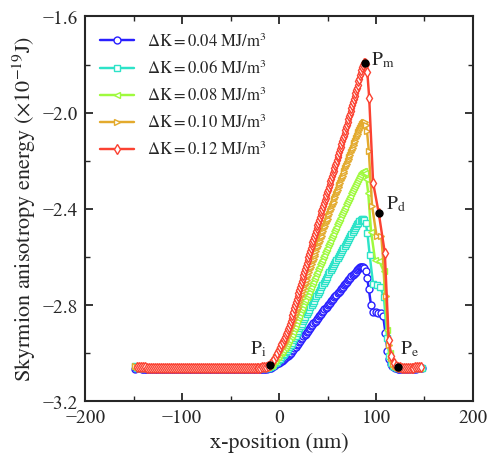

In [27]:
#各向异性能_K
import matplotlib as mpl
dfa = pd.read_csv('f:/csv_file/wenzhang2_EpK.csv')
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
custom_cycler = (cycler(color=['#291FFF'] + ['#2DE3C8'] + ['#9FFA3E'] + ['#E3AA2D'] + ['#FB4232']) +
                 cycler(markeredgecolor=['#291FFF'] + ['#2DE3C8'] + ['#9FFA3E'] + ['#E3AA2D'] + ['#FB4232']) +
                 cycler(marker=['o'] + ['s'] + ['<'] + ['>'] + ['d']) +
                 cycler(markerfacecolor=['w'] + ['w'] + ['w'] + ['w'] + ['w']))
fig, ax = plt.subplots(figsize=(5,5))
ax.set_prop_cycle(custom_cycler)
ax.plot(dfa['X40'][:-10],dfa['K40'][:-10]*1e19,label=r'$\mathrm{\Delta K=0.04\ MJ/m^{3}}$')
ax.plot(dfa['X60'][:-40],dfa['K60'][:-40]*1e19,label=r'$\mathrm{\Delta K=0.06\ MJ/m^{3}}$')
ax.plot(dfa['X80'][:-30],dfa['K80'][:-30]*1e19,label=r'$\mathrm{\Delta K=0.08\ MJ/m^{3}}$')
ax.plot(dfa['X100'],dfa['K100']*1e19,label=r'$\mathrm{\Delta K=0.10\ MJ/m^{3}}$')
ax.plot(dfa['X120'][1:],dfa['K120'][1:]*1e19,label=r'$\mathrm{\Delta K=0.12\ MJ/m^{3}}$')
ax.plot([dfa['X120'][68],dfa['X120'][176],dfa['X120'][181],dfa['X120'][187]],
        np.array([dfa['K120'][68],dfa['K120'][176],dfa['K120'][181],dfa['K120'][187]])*1e19,
        c='black',lw=0,marker='o',markersize=5,markerfacecolor='k',markeredgecolor='k')
ax.annotate(r'$\mathrm{P_{m}}$', xy=(dfa['X120'][176],dfa['K120'][176]*1e19), 
            xytext=(95, -1.8),fontsize=14)
ax.annotate(r'$\mathrm{P_{d}}$', xy=(dfa['X120'][181],dfa['K120'][181]*1e19), 
            xytext=(110, -2.4),fontsize=14)
ax.annotate(r'$\mathrm{P_{i}}$', xy=(dfa['X120'][68],dfa['K120'][68]*1e19), 
            xytext=(-30, -3),fontsize=14)
ax.annotate(r'$\mathrm{P_{e}}$', xy=(dfa['X120'][187],dfa['K120'][187]*1e19), 
            xytext=(125, -3),fontsize=14)
ax.spines[['bottom','left','top','right']].set_lw(1.5)
ax.set_xlabel('x-position (nm)',fontsize=16)
ax.set_ylabel(r'$\mathrm{Skyrmion\ anisotropy\ energy\ (\times10^{-19}J)}$',fontsize=16)
ax.set(xlim=(-200,200),ylim=(-3.2,-1.6))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=3.5,direction='in',width=1)
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=14,width=1.3)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.legend(loc='best',fontsize=12)
plt.savefig('f:/tupian/wenzhang2/PE_K.png',dpi=600,bbox_inches='tight')
plt.show()

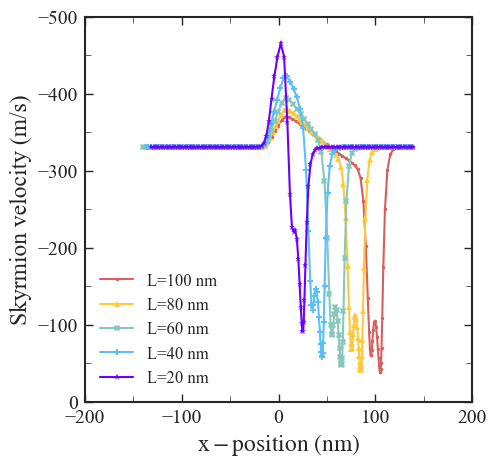

In [26]:
#速度曲线
import matplotlib as mpl
import pandas as pd
file_path = 'f:/csv_file/wenzhang2_J18_xv.csv'
dfa = pd.read_csv(file_path)
data = md.Data(name='wenzhang2')
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 1.5
custom_cycler = (cycler(color=['#D65F5F'] + ['#FFC93C'] + ['#86C8BC'] + ['#5BC0F8'] + ['#6C00FF']) +
                 cycler(markerfacecolor=['#D65F5F'] + ['#FFC93C'] + ['#86C8BC'] + ['#5BC0F8'] + ['#6C00FF']) +
                 cycler(marker=['.'] + ['^'] + ['X'] + ['P'] + ['*']))
fig, ax = plt.subplots(figsize=(5,5))
ax.set_prop_cycle(custom_cycler)
ax.plot(dfa['X100'][2:105],-dfa['v100'][2:105],label='L=100 nm')
ax.plot(dfa['X80'][3:],-dfa['v80'][3:],label='L=80 nm')
ax.plot(dfa['X60'][3:100],-dfa['v60'][3:100],label='L=60 nm')
ax.plot(dfa['X40'][3:115],-dfa['v40'][3:115],label='L=40 nm')
ax.plot(dfa['X20'][3:],-dfa['v20'][3:],label='L=20 nm')
ax.spines[['bottom','left','top','right']].set_lw(1.5)
ax.set_xlabel(r'$\mathrm{x-position\ (nm)}$',fontsize=17)
ax.set_ylabel('Skyrmion velocity (m/s)',fontsize=17)
ax.set(xlim=(-200,200),ylim=(0,-500))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=4,direction='in')
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.legend(loc='best',fontsize=12)
plt.savefig('f:/tupian/wenzhang2/varyL.png',dpi=600,bbox_inches='tight')
plt.show()

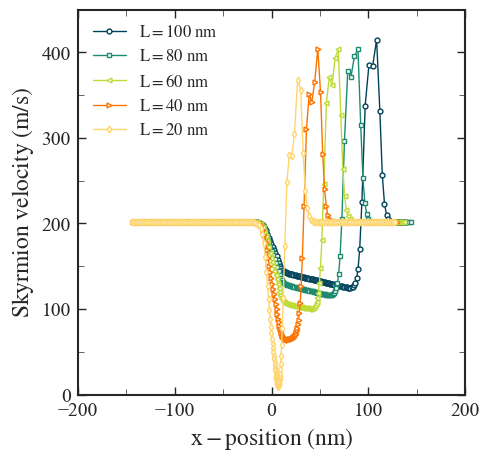

In [37]:
#速度曲线
import matplotlib as mpl
import pandas as pd
file_path = 'f:/csv_file/wenzhang2_J11_xv.csv'
dfa = pd.read_csv(file_path)
mpl.rcParams['lines.markersize'] = 3.5
mpl.rcParams['lines.markerfacecolor'] = 'white'
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
custom_cycler = (cycler(color=['#00425A'] + ['#1F8A70'] + ['#BFDB38'] + ['#FC7300'] + ['#FFD56F']) +
                 cycler(markeredgecolor=['#00425A'] + ['#1F8A70'] + ['#BFDB38'] + ['#FC7300'] + ['#FFD56F']) +
                 cycler(marker=['o'] + ['s'] + ['<'] + ['>'] + ['d']))
fig, ax = plt.subplots(figsize=(5,5))
ax.set_prop_cycle(custom_cycler)
ax.plot(dfa['X100'][5:190],dfa['v100'][5:190],label=r'$\mathrm{L=100\ nm}$')
ax.plot(dfa['X80'][3:180],dfa['v80'][3:180],label=r'$\mathrm{L=80\ nm}$')
ax.plot(dfa['X60'][3:],dfa['v60'][3:],label=r'$\mathrm{L=60\ nm}$')
ax.plot(dfa['X40'][3:],dfa['v40'][3:],label=r'$\mathrm{L=40\ nm}$')
ax.plot(dfa['X20'][2:],dfa['v20'][2:],label=r'$\mathrm{L=20\ nm}$')
ax.spines[['bottom','left','top','right']].set_lw(1.5)
ax.set_xlabel(r'$\mathrm{x-position\ (nm)}$',fontsize=17)
ax.set_ylabel(r'$\mathrm{Skyrmion\ velocity\ (m/s)}$',fontsize=17)
ax.set(xlim=(-200,200),ylim=(0,450))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.tick_params(axis='both',which='minor',length=4,direction='in')
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=14)
ax.legend(loc='best',fontsize=12)
plt.savefig('f:/tupian/wenzhang2/varyLJ.png',dpi=600,bbox_inches='tight')
plt.show()

In [38]:
#修改参数
for i in ['X100','X80','X60','X40','X20']:
    dfa1.loc[dfa1[i] > 150,i] = np.nan
    dfa1.loc[dfa1[i] < -150,i] = np.nan
    dfa1.to_csv(file_path1,index=None)

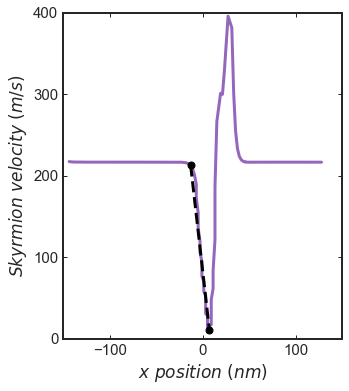

In [63]:
#单条曲线
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 7
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(5,6))
ax.plot(LJ20x[2:],LJ20v[2:],c='tab:purple',label=r'$\Delta L=20nm$',lw=3)
ax.plot([LJ20x[74]]+[LJ20x[116]],[LJ20v[74]]+[LJ20v[116]],marker='o',markerfacecolor='k',ls='--',c='k',lw=3)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x\ position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=17)
ax.set(xlim=(-150,150),ylim=(0,400))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.tick_params(axis='both',which='minor',length=0)
ax.tick_params(axis='both',which='major',length=4,direction='in',labelsize=15)
plt.savefig('f:/tupian/wenzhang2/xiaotu2.eps',dpi=600,bbox_inches='tight')
plt.show()

In [2]:
import pandas as pd
file_path = 'f:/csv_file/wenzhang2_J11_xv.csv'
dfa = pd.read_csv(file_path)
dfa

,X20,v20,X40,v40,X60,v60,X80,v80,X100,v100
0,-147.225494,195.826980,-147.629849,190.096960,-147.629513,190.140490,-147.224563,195.855843,-147.628860,190.227918
1,-145.409085,201.823257,-146.017042,201.600907,-146.016761,201.594110,-145.408402,201.795680,-146.016230,201.578871
2,-143.591363,201.969072,-144.398760,202.285248,-144.398528,202.279054,-143.590569,201.981462,-144.398081,202.268557
3,-141.772812,202.061258,-142.782383,202.047114,-142.782140,202.048496,-141.772052,202.057425,-142.781672,202.051134
4,-139.955683,201.903283,-141.166776,201.950894,-141.166529,201.951457,-139.954915,201.904092,-141.166056,201.952097
...,...,...,...,...,...,...,...,...,...,...
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.276589,0.003353
245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.276594,0.003292
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.276598,0.003252
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.276601,0.003222


In [5]:
#寻找数据点
dfa = pd.read_csv('f:/csv_file/wenzhang2_J18_xv.csv')
x_min = dfa[dfa['v100'] == dfa['v100'].min()].index.values[0]
x_max = dfa[dfa['v100'] == dfa['v100'].max()].index.values[0]
x_0 = dfa[dfa.diff()['v100'] <= -0.5].index.values[0]
x_1 = dfa[x_min:x_min+10][dfa[x_min:x_min+10].diff()['v100'] <= -0.5].index.values[0]
x_2 = dfa[x_1:x_1+10][dfa[x_1:x_1+10].diff()['v100'] >= 0.5].index.values[0]
x_3 = dfa[x_2:][dfa[x_2:].diff()['v100'] >= 10].index.values[-1]
x_4 = dfa[x_max:x_max+10][dfa[x_max:x_max+10].diff()['v100'] <= -1].index.values[-1]
print(x_min, x_max, x_0, x_1-1, x_2-1, x_3, x_4)

17 60 7 25 31 38 67


In [35]:
#寻找数据点
dfa = pd.read_csv('f:/csv_file/wenzhang2_J11_xv.csv')
x_min = dfa[:-60][dfa[:-60]['v100'] == dfa[:-60]['v100'].min()].index.values[0]
x_max = dfa[dfa['v100'] == dfa['v100'].max()].index.values[0]
x_0 = dfa[x_max:x_max+10][dfa[x_max:x_max+10].diff()['v100'] >= -0.5].index.values[0]
x_1 = dfa[dfa.diff()['v100'] <= -1].index.values[0]
x_2 = dfa[x_1:][dfa[x_1:].diff()['v100'] >= -1].index.values[0]
print(x_min, x_max, x_0-1, x_1-1, x_2-1)

162 175 182 85 103


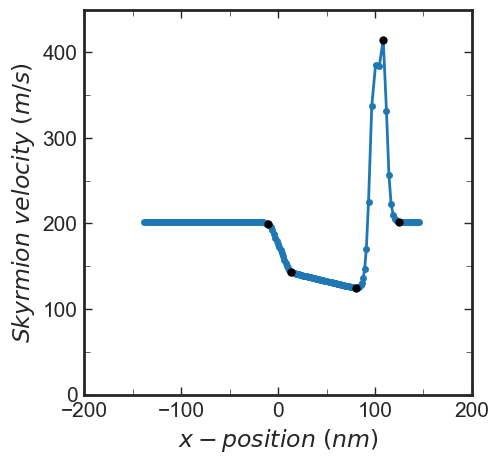

In [39]:
#单条曲线（修改审稿意见）
import matplotlib as mpl
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfa['X100'][6:-56],dfa['v100'][6:-56],c='tab:blue',lw=2,marker='o',markersize=5)
ax.plot([dfa['X100'][162],dfa['X100'][175],dfa['X100'][182],dfa['X100'][85],dfa['X100'][103]],
        [dfa['v100'][162],dfa['v100'][175],dfa['v100'][182],dfa['v100'][85],dfa['v100'][103]],
        c='black',lw=0,marker='o',markersize=6)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x-position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=17)
ax.set(xlim=(-200,200),ylim=(0,450))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.tick_params(axis='both',which='minor',length=4,direction='in')
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15)
plt.savefig('f:/tupian/wenzhang2/L100+_quxian0.eps',dpi=600,bbox_inches='tight')
plt.show()

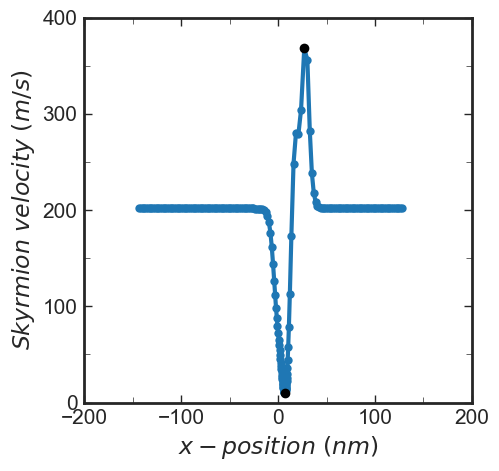

In [3]:
#单条曲线（修改审稿意见）
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 6
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfa['X20'][2:],dfa['v20'][2:],c='tab:blue',lw=3,marker='o')
ax.plot([dfa['X20'][116],dfa['X20'][144]],[dfa['v20'][116],dfa['v20'][144]],c='black',lw=0,marker='o',markersize=7)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x-position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=17)
ax.set(xlim=(-200,200),ylim=(0,400))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.tick_params(axis='both',which='minor',length=4,direction='in')
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15)
plt.savefig('f:/tupian/wenzhang2/L20_quxian0.eps',dpi=600,bbox_inches='tight')
plt.show()

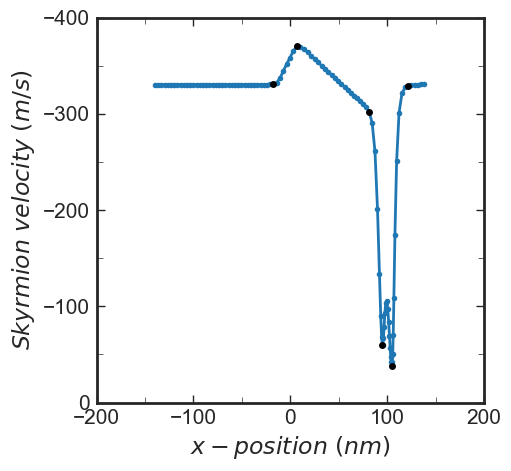

In [6]:
#单条曲线（修改审稿意见）
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 4
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfa['X100'][2:-95],-dfa['v100'][2:-95],c='tab:blue',lw=2,marker='o')
ax.plot([dfa['X100'][7],dfa['X100'][17],dfa['X100'][67],dfa['X100'][31],dfa['X100'][38],dfa['X100'][60]],
        [-dfa['v100'][7],-dfa['v100'][17],-dfa['v100'][67],-dfa['v100'][31],-dfa['v100'][38],-dfa['v100'][60]],
        c='black',lw=0,marker='o',markersize=5)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x-position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=17)
ax.set(xlim=(-200,200),ylim=(0,-400))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.tick_params(axis='both',which='minor',length=4,direction='in')
ax.tick_params(axis='both',which='major',length=6,direction='in',labelsize=15)
plt.savefig('f:/tupian/wenzhang2/L100_quxian0.eps',dpi=600,bbox_inches='tight')
plt.show()

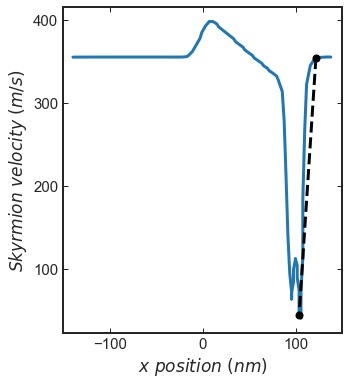

In [62]:
#单条曲线
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 7
plt.style.use('seaborn-white')
custom_cycler = (cycler(color=['tab:blue'] + ['tab:orange'] + ['tab:green'] + ['tab:red'] + ['tab:purple']) +
                 cycler(markeredgecolor=['tab:blue'] + ['tab:orange'] + ['tab:green'] + ['tab:red'] + ['tab:purple']))
fig, ax = plt.subplots(figsize=(5,6))
ax.set_prop_cycle(custom_cycler)
ax.plot(L100x[2:105],L100v[2:105],label=r'$\Delta L=100nm$',lw=3)
ax.plot([L100x[7]]+[L100x[19]],[L100v[7]]+[L100v[19]],marker='o',ls='--',c='k',markerfacecolor='k',markeredgecolor='k',lw=3)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x\ position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$Skyrmion\ velocity\ (m/s)$',fontsize=17)
ax.set(xlim=(-150,150))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=0)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=15)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
plt.savefig('f:/tupian/wenzhang2/xiaotu.eps',dpi=600,bbox_inches='tight')
plt.show()

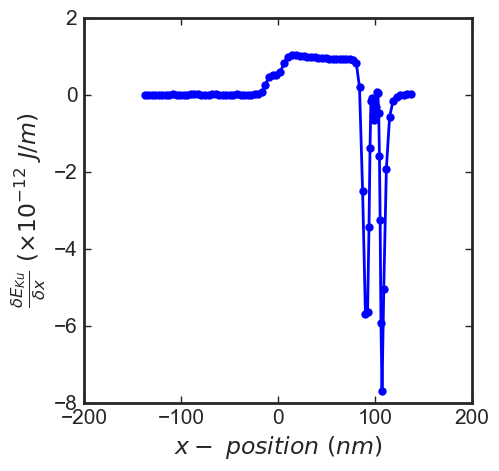

In [52]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
plt.style.use('seaborn-v0_8-white')
dfa = pd.read_csv('f:/csv_file/wenzhang2_tu1_xv.csv')
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfa['NX20'][2:-110],
       np.array(dfa['NE20'].diff()[2:-110]/dfa['NX20'].diff()[2:-110])*10**21,
       lw=2,marker='o',c='b',markersize=6)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.set_xlabel(r'$x-\ position\ (nm)$',fontsize=17)
ax.set_ylabel(r'$\frac{\delta E_{Ku}}{\delta x}\ (\times 10^{-12}\ J/m)$',fontsize=17)
ax.set(xlim=(-200,200),ylim=(-8,2))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=0)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=15)
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
plt.savefig('f:/tupian/wenzhang2/bizhi.eps',dpi=600,bbox_inches='tight')
plt.show()

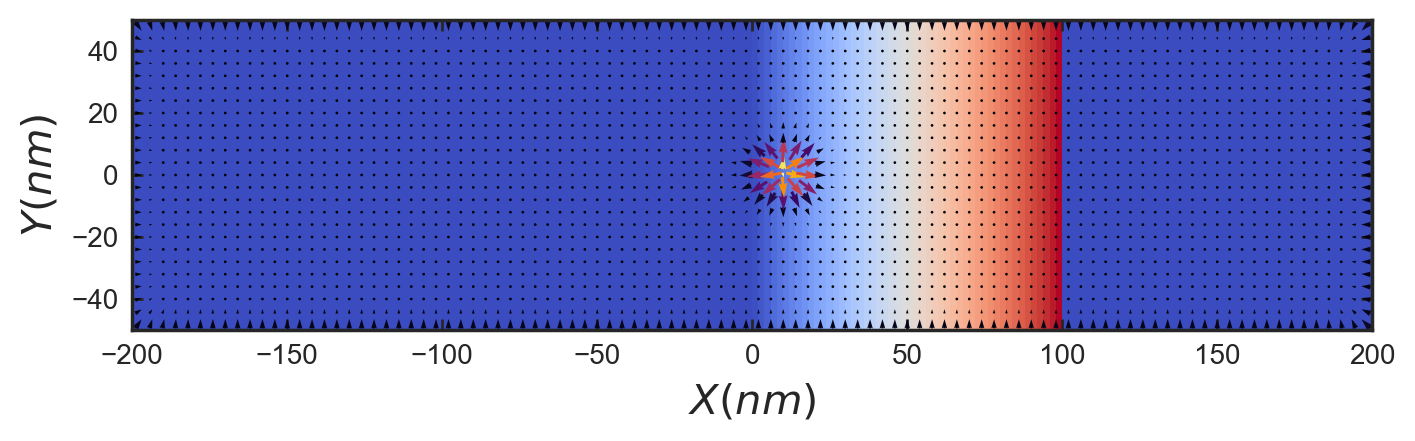

In [8]:
#磁矩图
plt.style.use('seaborn-v0_8-white')
data = md.Data(name='wenzhang2')
N = 42
i = -1
fig, ax = plt.subplots(dpi=200)
data[N][i].plane(z=25e-10,n=(100,25)).mpl.vector(ax=ax,scale=3e7,cmap='inferno',colorbar=False,
                                      color_field=data[N][i].z)
df.Field.fromfile(r'F:\模拟文件2\wenzhang2\drive-{}\uniaxialanisotropy_K.ovf'.format(42)).x.plane(z=25e-10).mpl.scalar(ax=ax,cmap='coolwarm',alpha=1,colorbar=False)
ax.set(xlabel=r'$X(nm)$',ylabel=r'$Y(nm)$',xlim=(-200,200),ylim=(-50,50))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='major',length=4,labelsize=10,direction='in')
plt.savefig('f:/tupian/wenzhang2/.eps',dpi=600,bbox_inches='tight')
plt.show()

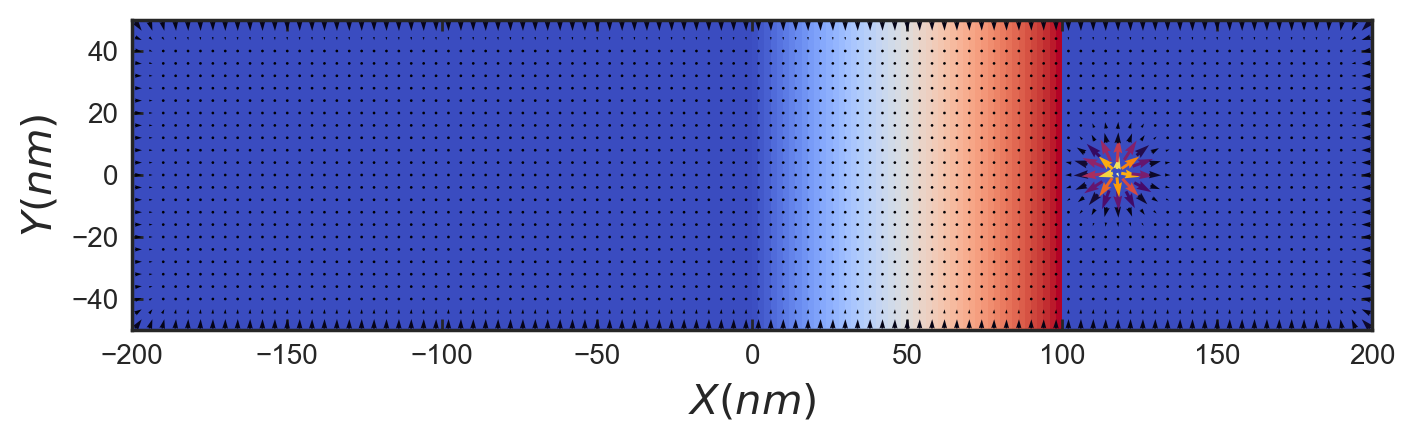

In [34]:
#磁矩图(修改审稿意见)
plt.style.use('seaborn-v0_8-white')
data = md.Data(name='wenzhang2')
N = 15
i = 30
fig, ax = plt.subplots(dpi=200)
data[N][i].plane(z=25e-10,n=(100,25)).mpl.vector(ax=ax,scale=3e7,cmap='inferno',colorbar=False,
                                      color_field=data[N][i].z)
df.Field.fromfile(r'F:\模拟文件2\wenzhang2\drive-{}\uniaxialanisotropy_K.ovf'.format(N)).x.plane(z=25e-10).mpl.scalar(ax=ax,cmap='coolwarm',alpha=1,colorbar=False)
ax.set(xlabel=r'$X(nm)$',ylabel=r'$Y(nm)$',xlim=(-200,200),ylim=(-50,50))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='major',length=4,labelsize=10,direction='in')
plt.savefig('f:/tupian/wenzhang2/L100+_4.eps',dpi=600,bbox_inches='tight')
plt.show()

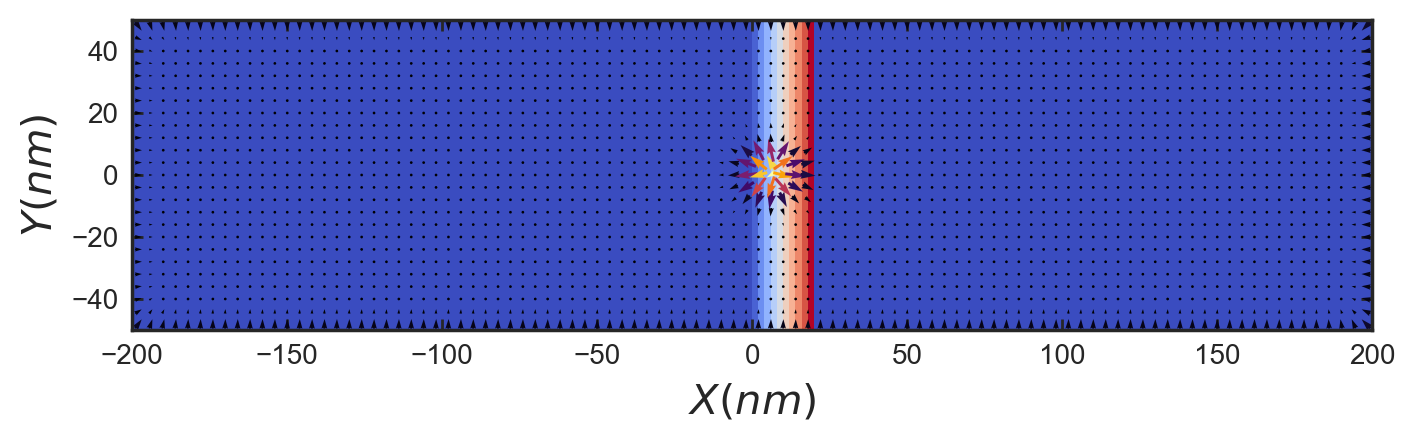

In [42]:
#磁矩图(修改审稿意见)
plt.style.use('seaborn-v0_8-white')
data = md.Data(name='wenzhang2')
N = 23
i = 116
fig, ax = plt.subplots(dpi=200)
data[N][i].plane(z=25e-10,n=(100,25)).mpl.vector(ax=ax,scale=3e7,cmap='inferno',colorbar=False,
                                      color_field=data[N][i].z)
df.Field.fromfile(r'F:\模拟文件2\wenzhang2\drive-{}\uniaxialanisotropy_K.ovf'.format(N)).x.plane(z=25e-10).mpl.scalar(ax=ax,cmap='coolwarm',alpha=1,colorbar=False)
ax.set(xlabel=r'$X(nm)$',ylabel=r'$Y(nm)$',xlim=(-200,200),ylim=(-50,50))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='major',length=4,labelsize=10,direction='in')
plt.savefig('f:/tupian/wenzhang2/L20_1.eps',dpi=600,bbox_inches='tight')
plt.show()

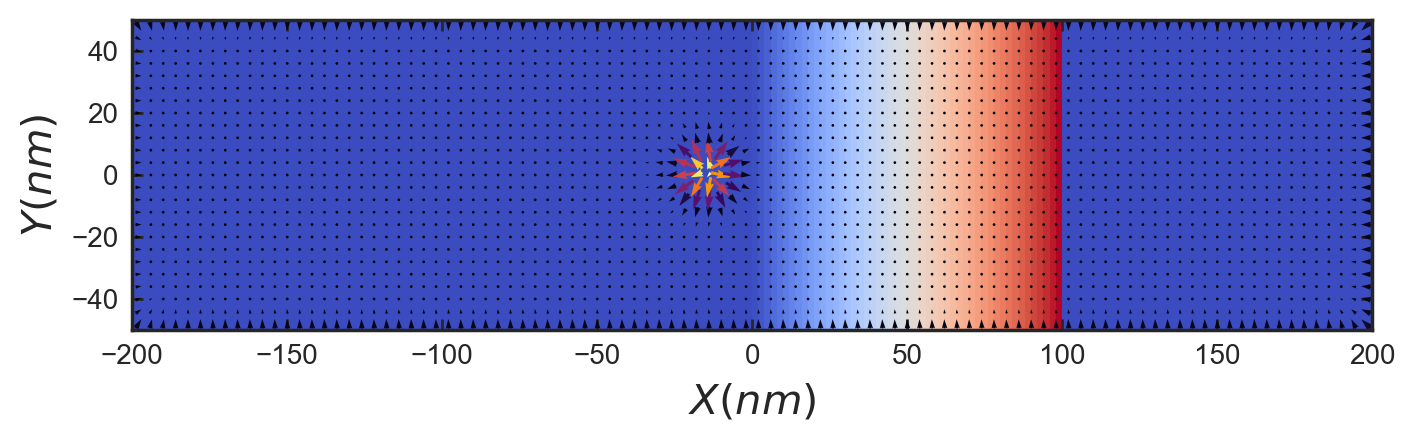

In [108]:
#磁矩图(修改审稿意见)
plt.style.use('seaborn-v0_8-white')
data = md.Data(name='wenzhang2')
N = 4
i = 67
fig, ax = plt.subplots(dpi=200)
data[N][i].plane(z=25e-10,n=(100,25)).mpl.vector(ax=ax,scale=3e7,cmap='inferno',colorbar=False,
                                      color_field=data[N][i].z)
df.Field.fromfile(r'F:\模拟文件2\wenzhang2\drive-{}\uniaxialanisotropy_K.ovf'.format(N)).x.plane(z=25e-10).mpl.scalar(ax=ax,cmap='coolwarm',alpha=1,colorbar=False)
ax.set(xlabel=r'$X(nm)$',ylabel=r'$Y(nm)$',xlim=(-200,200),ylim=(-50,50))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='major',length=4,labelsize=10,direction='in')
plt.savefig('f:/tupian/wenzhang2/L100_5.eps',dpi=600,bbox_inches='tight')
plt.show()

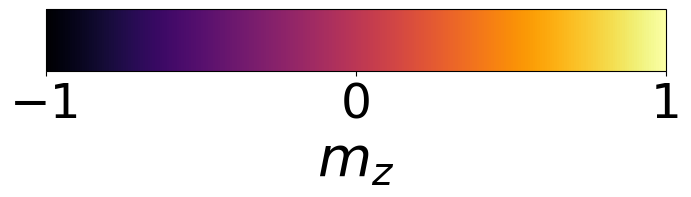

In [9]:
#制作colorbar(horizontal)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,0.8))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.cm.inferno
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,
                      ticks=[-1,0,1],orientation='horizontal')
cbar.set_label(label=r'$m_{z}$',fontsize=40)
cbar.ax.tick_params(labelsize=35)
plt.savefig('f:/tupian/wenzhang2/cbar.png',dpi=600,bbox_inches='tight')
plt.show()

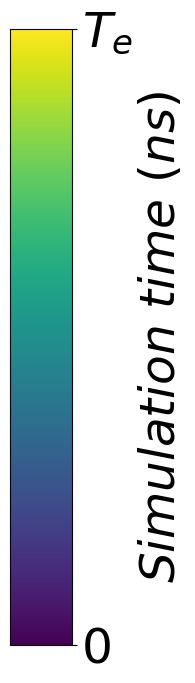

In [5]:
#制作colorbar(vertical)
fig, ax = plt.subplots(figsize=(0.8,8))
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap='viridis'),
                    cax=ax,ticks=[0,1],orientation='vertical')
cbar.set_label(label=r'$Simulation\ time\ (ns)$',fontsize=35)
cbar.ax.set_yticklabels(['0','$T_{e}$'],fontsize=35)
plt.savefig('f:/tupian/wenzhang2/cbar3.png',dpi=600,bbox_inches='tight')
plt.show()

In [2]:
# write vtk file
data = md.Data(name='wenzhang2')
data[14][20].orientation.write('f:/vtk_file/wenzhang2_0.vtk')